In [0]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('/content/drive/My Drive/pyross')
%run setup.py install

In [0]:
import pyross

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
print(os.getcwd())

/content/drive/My Drive/pyross


In [0]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('/content/drive/My Drive/pyross/examples/data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)
print(Ni,N)

[1.16781822e+08 1.19950007e+08 1.26984911e+08 1.25689425e+08
 1.21797336e+08 1.16684121e+08 1.11060977e+08 1.01338706e+08
 8.81598690e+07 7.77216210e+07 6.74327810e+07 5.79461730e+07
 4.77210000e+07 3.65752750e+07 2.28444050e+07 1.46562800e+07] 1353344709.0


In [0]:
os.chdir('/content/drive/My Drive/pyross/examples/deterministic')
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

In [0]:
beta  = 0.01646692       # infection rate 
gIa   = 1./7             # recovery rate of asymptomatic infectives 
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1

Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)



# matrix for linearised dynamics
def R0(C):
    L0 = np.zeros((M, M))
    L  = np.zeros((2*M, 2*M))

    for i in range(M):
        for j in range(M):
            L0[i,j]=C[i,j]*Ni[i]/Ni[j]

    L[0:M, 0:M]     =    alpha*beta/gIs*L0
    L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
    L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
    L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0

    return np.max(np.linalg.eigvals(L))

r0 = R0(C)
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (2.2369030223732502+0j)


In [0]:
# duration of simulation and data file
Tf=21*2-1;  Nf=2000;  

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [0]:
data

{'M': 16,
 'N': 1353344709,
 'X': array([[1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         1.26929944e-03, 6.34640613e-04, 3.97745500e-04],
        [1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         2.53639904e-03, 1.26800473e-03, 7.94809098e-04],
        ...,
        [1.16780127e+08, 1.19946410e+08, 1.26980008e+08, ...,
         1.18998319e+02, 5.87682053e+01, 4.19825188e+01],
        [1.16780121e+08, 1.19946397e+08, 1.26979990e+08, ...,
         1.19429750e+02, 5.89813885e+01, 4.21348553e+01],
        [1.16780115e+08, 1.19946384e+08, 1.26979972e+08, ...,
         1.19862747e+02, 5.91953457e+01, 4.22877450e+01]]),
 'alpha': 0.0,
 'beta': 0.01646692,
 'gIa': 0.14285714285714285,
 'gIs': 0.14285714285714285,
 't': array([0.00000000e+00, 2.05102551e-02, 4.10205103e-02, ...,
        4.09589795e+01, 4.09794897e+01, 4.10000000e+01])}

In [0]:
data['X'].shape

(2000, 48)

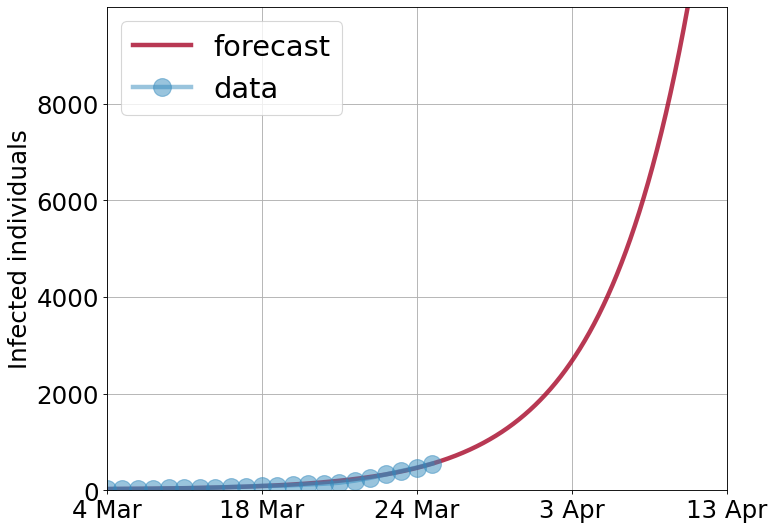

In [0]:
t = data['t']; IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, Tf, 10), ('4 Mar', '18 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr'));

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]


plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 40); plt.ylim(0, 9999);

#SIR Model without Mitigation

In [0]:
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# the contact matrix is time-dependent
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=98.5;  Nf=2000 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [0]:
data

{'M': 16,
 'N': 1353344709,
 'X': array([[1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         3.04571194e-03, 1.52253680e-03, 9.54411687e-04],
        [1.16781822e+08, 1.19950007e+08, 1.26984910e+08, ...,
         6.07884719e-03, 3.03777247e-03, 1.90492820e-03],
        ...,
        [1.16600170e+08, 1.19565134e+08, 1.26459374e+08, ...,
         1.27635310e+04, 6.30591496e+03, 4.50522880e+03],
        [1.16598589e+08, 1.19561788e+08, 1.26454809e+08, ...,
         1.28745749e+04, 6.36076671e+03, 4.54440989e+03],
        [1.16596995e+08, 1.19558414e+08, 1.26450205e+08, ...,
         1.29865800e+04, 6.41609304e+03, 4.58392984e+03]]),
 'alpha': 0.0,
 'beta': 0.01646692,
 'gIa': 0.14285714285714285,
 'gIs': 0.14285714285714285,
 't': array([0.00000000e+00, 4.92746373e-02, 9.85492746e-02, ...,
        9.84014507e+01, 9.84507254e+01, 9.85000000e+01])}

In [0]:
data['t'].shape

(2000,)

(0.0, 98.0)

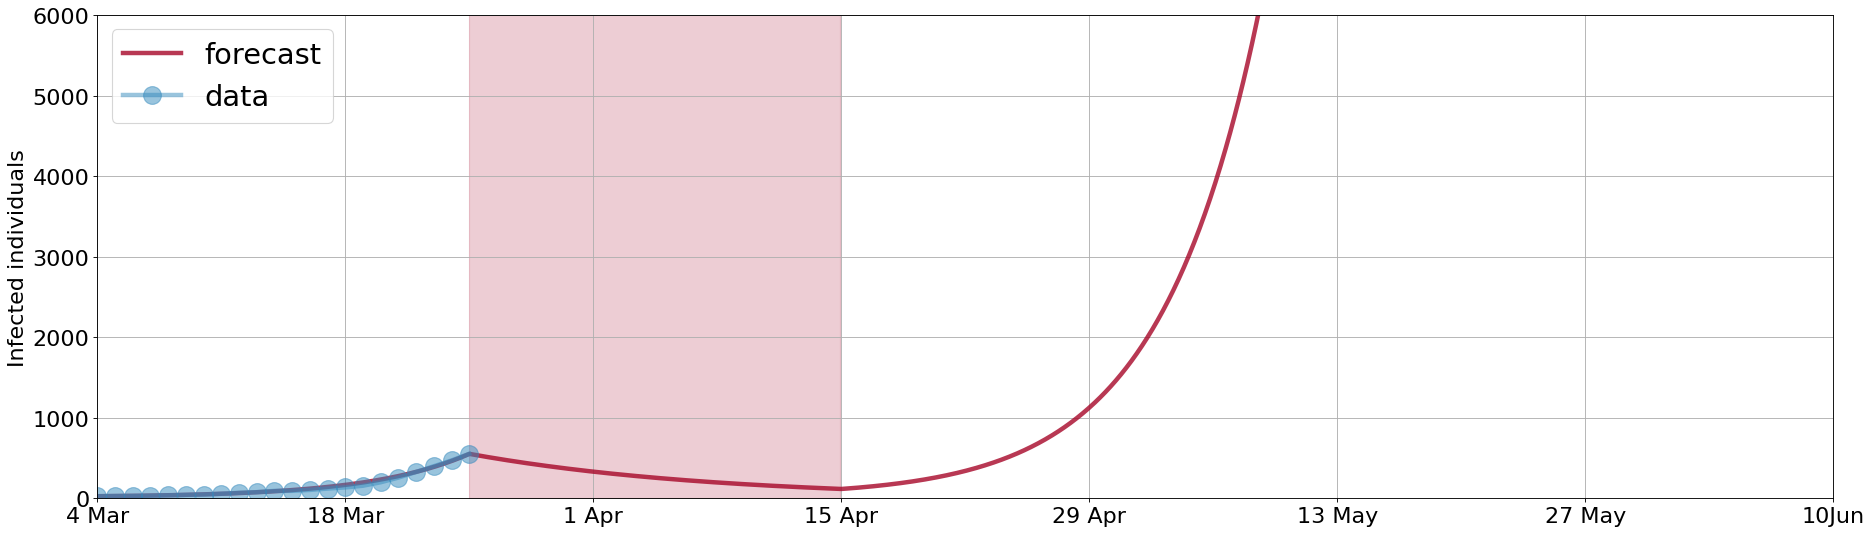

In [0]:
IC  = np.zeros((Nf))


for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']


fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 20})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'))
t1=int(Nf/14)
plt.fill_between(t[3*t1:6*t1], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left') 
plt.grid()
plt.ylabel('Infected individuals')
plt.ylim(0, 6000)
plt.xlim(0, 98)